In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pyspark.sql.functions as F

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName('MMDS').getOrCreate()

#Load dataset


Dùng inferSchema tự động suy luận kiểu dữ liệu
Dữ liệu không quá lớn và phức tạp, dữ liệu ở các cột có cấu trúc đơn giản
Chọn inferSchema sẽ tiết kiệm thời gian cấu hình và hoạt động tốt ở dữ liệu này


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MMDS/Midterm/baskets.csv'
df = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [ ]:
df.show(5)

+-------------+----------+----------------+----+-----+---+-----------+
|Member_number|      Date| itemDescription|year|month|day|day_of_week|
+-------------+----------+----------------+----+-----+---+-----------+
|         1249|01/01/2014|    citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|          coffee|2014|    1|  1|          2|
|         1381|01/01/2014|            curd|2014|    1|  1|          2|
|         1381|01/01/2014|            soda|2014|    1|  1|          2|
|         1440|01/01/2014|other vegetables|2014|    1|  1|          2|
+-------------+----------+----------------+----+-----+---+-----------+
only showing top 5 rows



# BasketAnalysis Class

In [37]:
class BasketAnalysis:
    def __init__(self, input_path, output_folder_path):
        """Khởi tạo Spark session và đọc file CSV"""
        self.spark = (SparkSession
                      .builder
                      .appName('BasketAnalysis')
                      .getOrCreate())

        self.input_path = input_path
        self.output_folder_path = output_folder_path

        self.df = (self.spark
                   .read
                   .csv(self.input_path,
                    header=True, inferSchema=True))

    def plot_bar(self, data, x_col, y_col, title, x_label, y_label,
                            output_csv=None, invert_y=False):
        """
        Vẽ biểu đồ cột và lưu kết quả.
        Params
            data: DataFrame chứa dữ liệu để vẽ.
            x_col: Tên cột trục X.
            y_col: Tên cột trục Y.
            title: Tiêu đề biểu đồ.
            x_label: Nhãn trục X.
            y_label: Nhãn trục Y.
            output_csv: Đường dẫn lưu file CSV.
            output_img: Đường dẫn lưu ảnh.
            invert_y: Đảo ngược trục Y nếu True.
        """
        plt.figure(figsize=(20, 15))
        # Lấy bảng màu tab20
        colors = plt.get_cmap("tab20").colors
        color_list = [colors[i % len(colors)] for i in range(len(data))]

        if invert_y:
            plt.barh(data[x_col].astype(str), data[y_col], color=color_list)
            plt.gca().invert_yaxis()
        else:
            plt.bar(data[x_col].astype(str), data[y_col], color=color_list)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.tight_layout()

        if output_csv:
            data.to_csv(output_csv, index=False)
        plt.show()


    def f1(self):

        """F1: Thống kê số lần mỗi món hàng được mua và vẽ biểu đồ."""


        """Lọc danh sách món hàng và đếm số lần mỗi món hàng được mua"""
        items_count = df.groupBy("itemDescription") \
                .agg(F.count("*").alias("count")) \
                .sort("count", ascending=False)

        top_items = items_count.limit(100).toPandas()
        print(top_items)
        self.plot_bar(
            top_items, "itemDescription", "count",
            "Top 100 Items Purchased", "Purchase Count", "Item Description",
            f"{self.output_folder_path}/f1/top_100_items.csv",
            invert_y=True
        )


    def f2(self):

        """F2: Thống kê số lượng giỏ hàng của từng người dùng."""

        """
        Nhóm dữ liệu theo Member_number và Date, mỗi nhóm ứng với
        1 giỏ hàng(các itemDescription) mà khách hàng mua trong 1 ngày,
        Đếm số lượng giỏ hàng mà mỗi người dùng đã mua theo ngày
        """
        user_basket_count = self.df.groupBy("Member_number", "Date") \
                                   .agg(F.collect_list("itemDescription")
                                        .alias("Grouped_items")) \
                                   .groupBy("Member_number") \
                                   .agg(F.count("Date").alias("basket_count")) \
                                   .sort("basket_count", ascending=False)


        top_users = user_basket_count.limit(100).toPandas()
        print(top_users)
        self.plot_bar(
            top_users, "Member_number", "basket_count",
            "Top 100 Users with Most Baskets", "Basket Count", "User ID",
            f"{self.output_folder_path}/f2/top_100_users.csv",
            invert_y=True
        )


    def f3(self, item_name):

        """F3: Thống kê số lần mua món hàng cụ thể theo tháng."""

        """Lọc theo giỏ hàng chứa món hàng"""
        filtered_df = self.df.filter(F.col("itemDescription").like(item_name))

        """Nhóm dữ liệu theo tháng và tính số lần món hàng được mua"""
        monthly_sales = filtered_df.groupBy("month") \
                                   .agg(F.count("*")
                                   .alias(f"# sold {item_name} per month")) \
                                   .sort("month")

        monthly_sales_pd = monthly_sales.toPandas()
        print(monthly_sales_pd)
        self.plot_bar(
            monthly_sales_pd, "month", f"# sold {item_name} per month",
            f'Monthly Sales of {item_name}', 'Month',
            f'Sales Count of {item_name}',
            f"{self.output_folder_path}/f3/monthly_sales.csv"
        )


    def f4(self, customer_id):

        """F4: Thống kê số lần mua hàng của khách hàng theo từng tháng."""

        """Lọc dữ liệu khách hàng theo id"""
        filtered_df = self.df.filter(F.col("Member_number") == customer_id)

        """Nhóm dữ liệu theo tháng và tính số lần mua hàng cho từng tháng"""
        monthly_purchases = filtered_df.groupBy("month") \
                                .agg(F.count("*")
                                .alias(f"# purchases by customer {customer_id}")) \
                                .sort("month")


        monthly_purchases_pd = monthly_purchases.toPandas()
        print(monthly_purchases_pd)
        self.plot_bar(
            monthly_purchases_pd, "month",
            f"# purchases by customer {customer_id}",
            f'Monthly Purchases of Customer {customer_id}', 'Month',
            f'Purchase Count by Customer {customer_id}',
            f"{self.output_folder_path}/f4/monthly_purchases.csv",
        )

# Test

In [38]:
input_path = '/content/drive/MyDrive/MMDS/Midterm/baskets.csv'
output_folder= '/content/drive/MyDrive/MMDS/Midterm/output'
analysis = BasketAnalysis(input_path, output_folder)


       itemDescription  count
0           whole milk   2502
1     other vegetables   1898
2           rolls/buns   1716
3                 soda   1514
4               yogurt   1334
..                 ...    ...
95  liquor (appetizer)     67
96            dog food     67
97             candles     66
98   finished products     64
99      instant coffee     61

[100 rows x 2 columns]


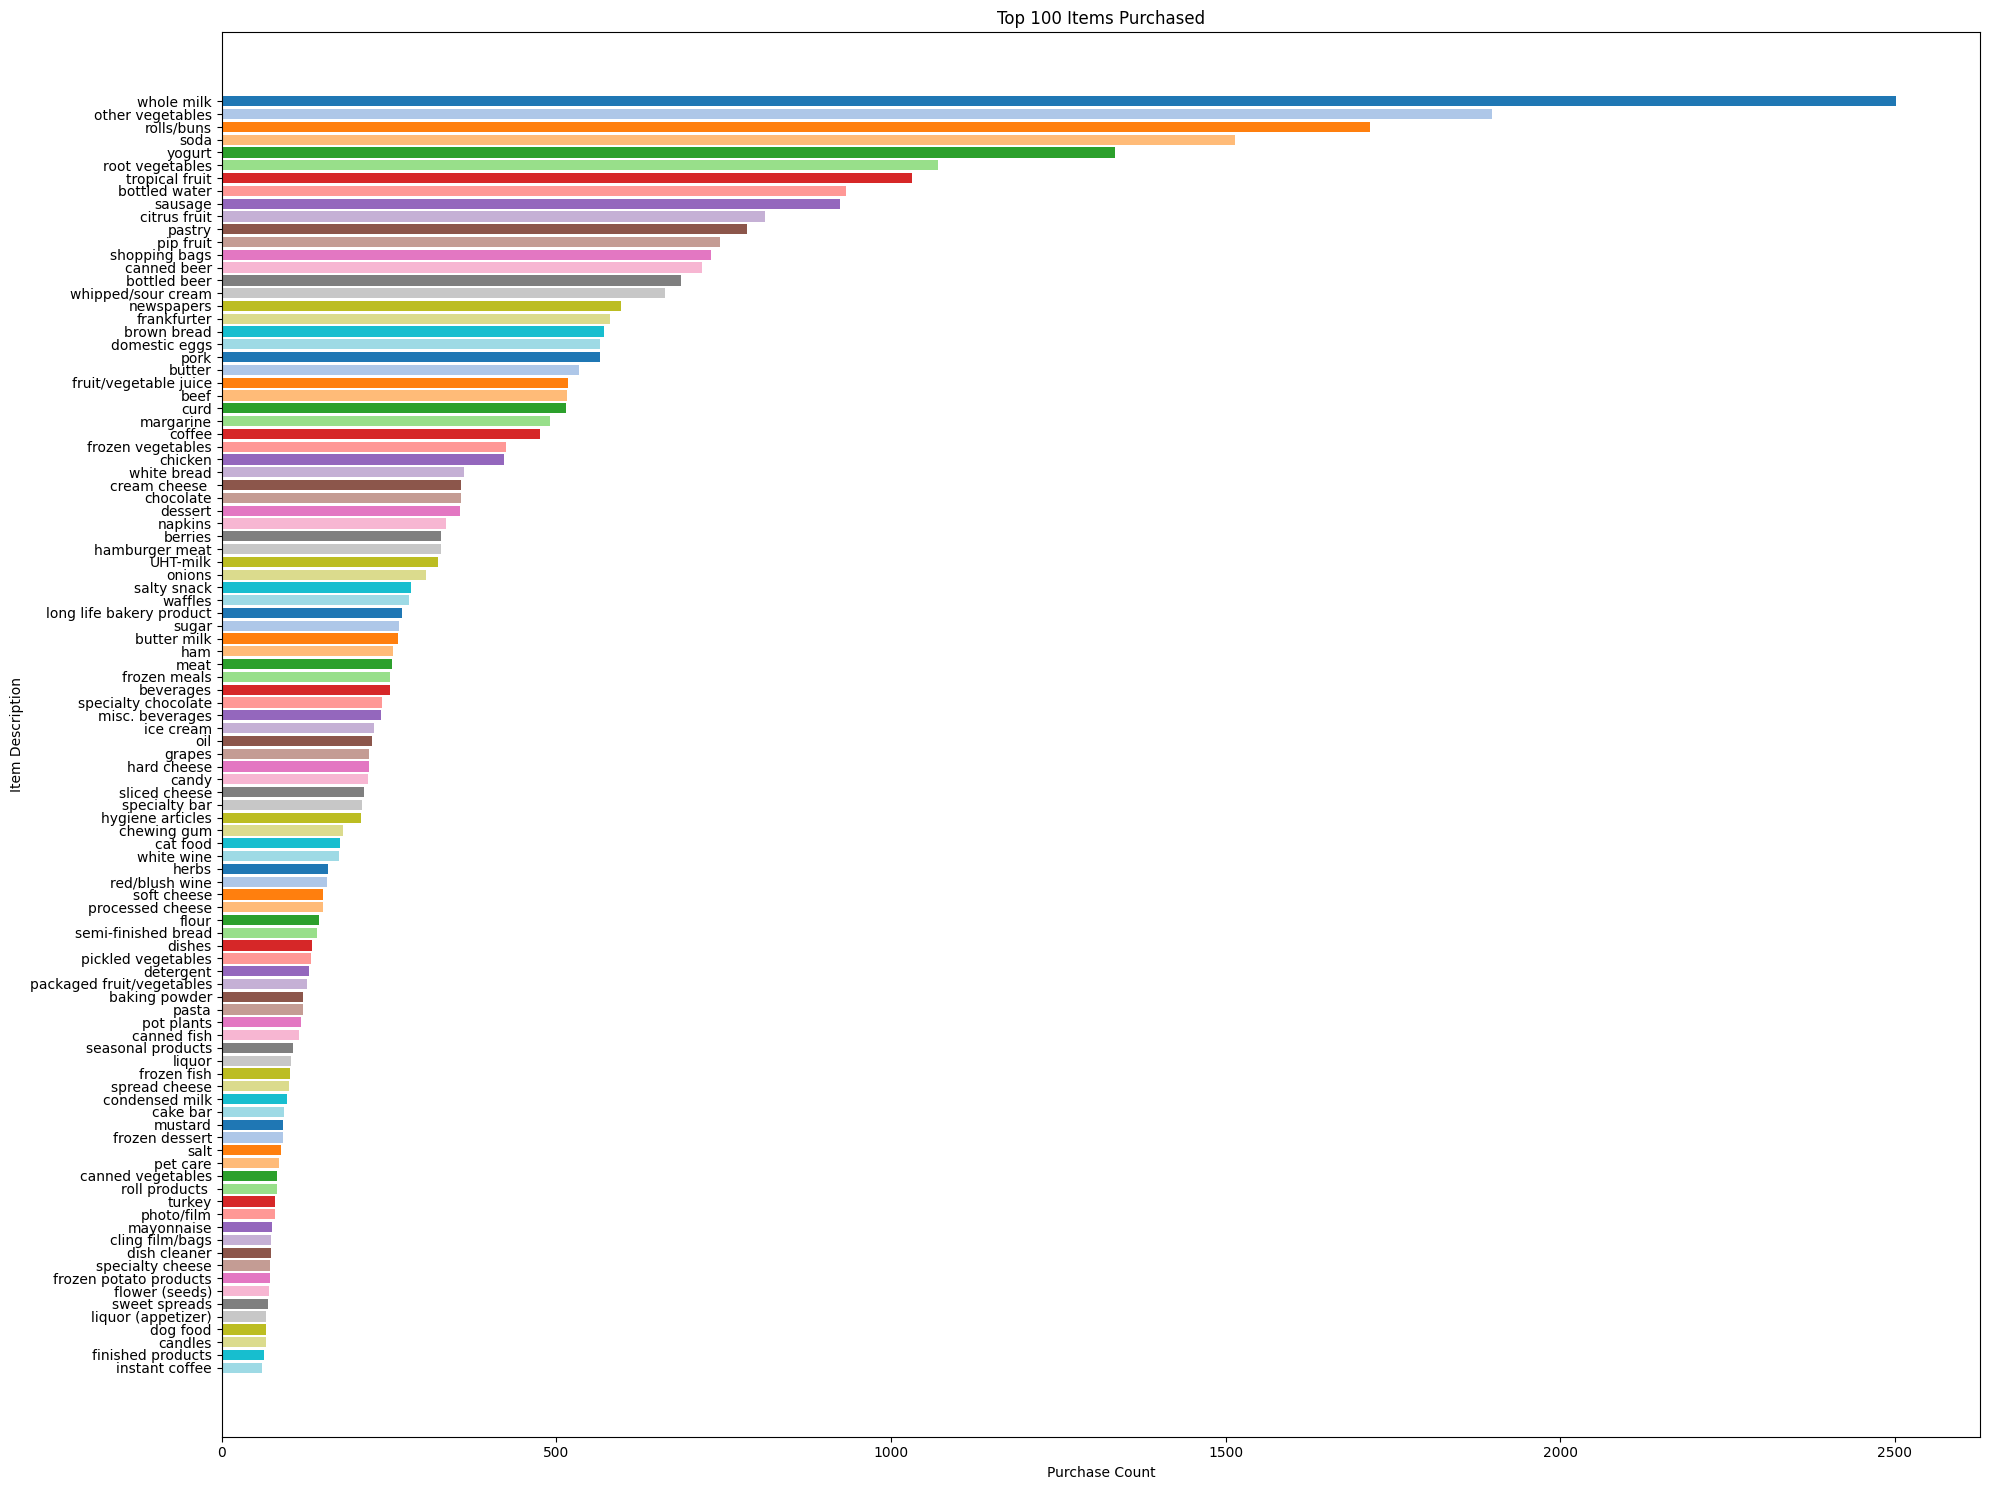

In [39]:
analysis.f1()

    Member_number  basket_count
0            4338            11
1            2193            11
2            2271            11
3            1379            11
4            3737            11
..            ...           ...
95           3663             8
96           1711             8
97           1979             8
98           3517             8
99           4694             8

[100 rows x 2 columns]


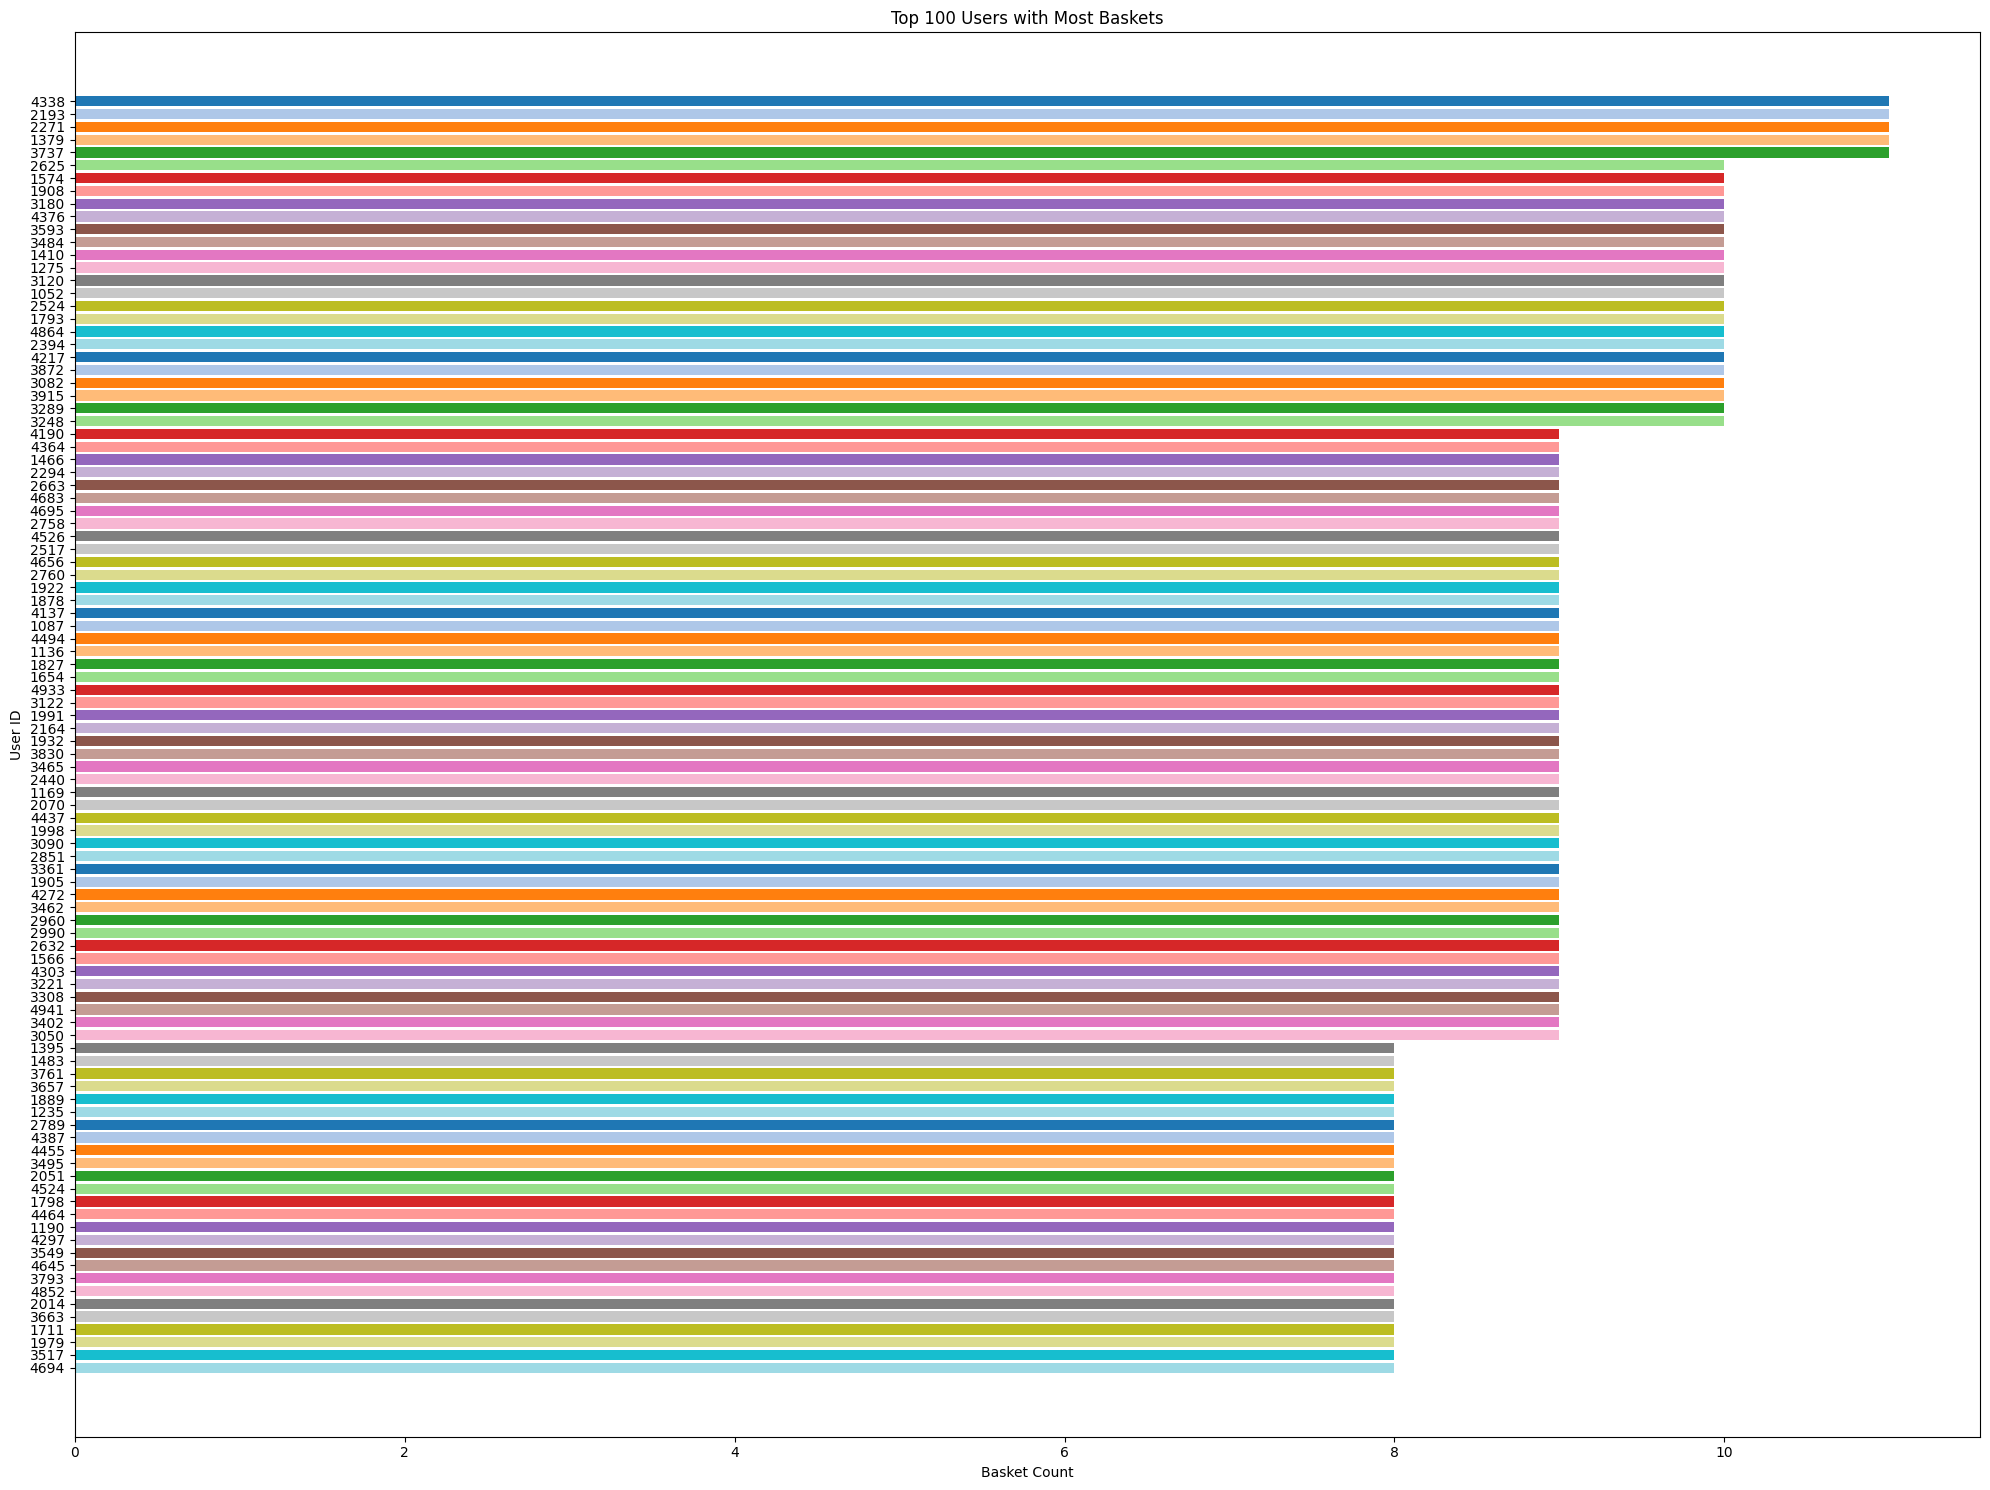

In [40]:
analysis.f2()

    month  # sold dish cleaner per month
0       1                              7
1       2                              4
2       3                              6
3       4                              8
4       5                              4
5       6                              8
6       7                              6
7       8                              5
8       9                              3
9      10                             10
10     11                              8
11     12                              4


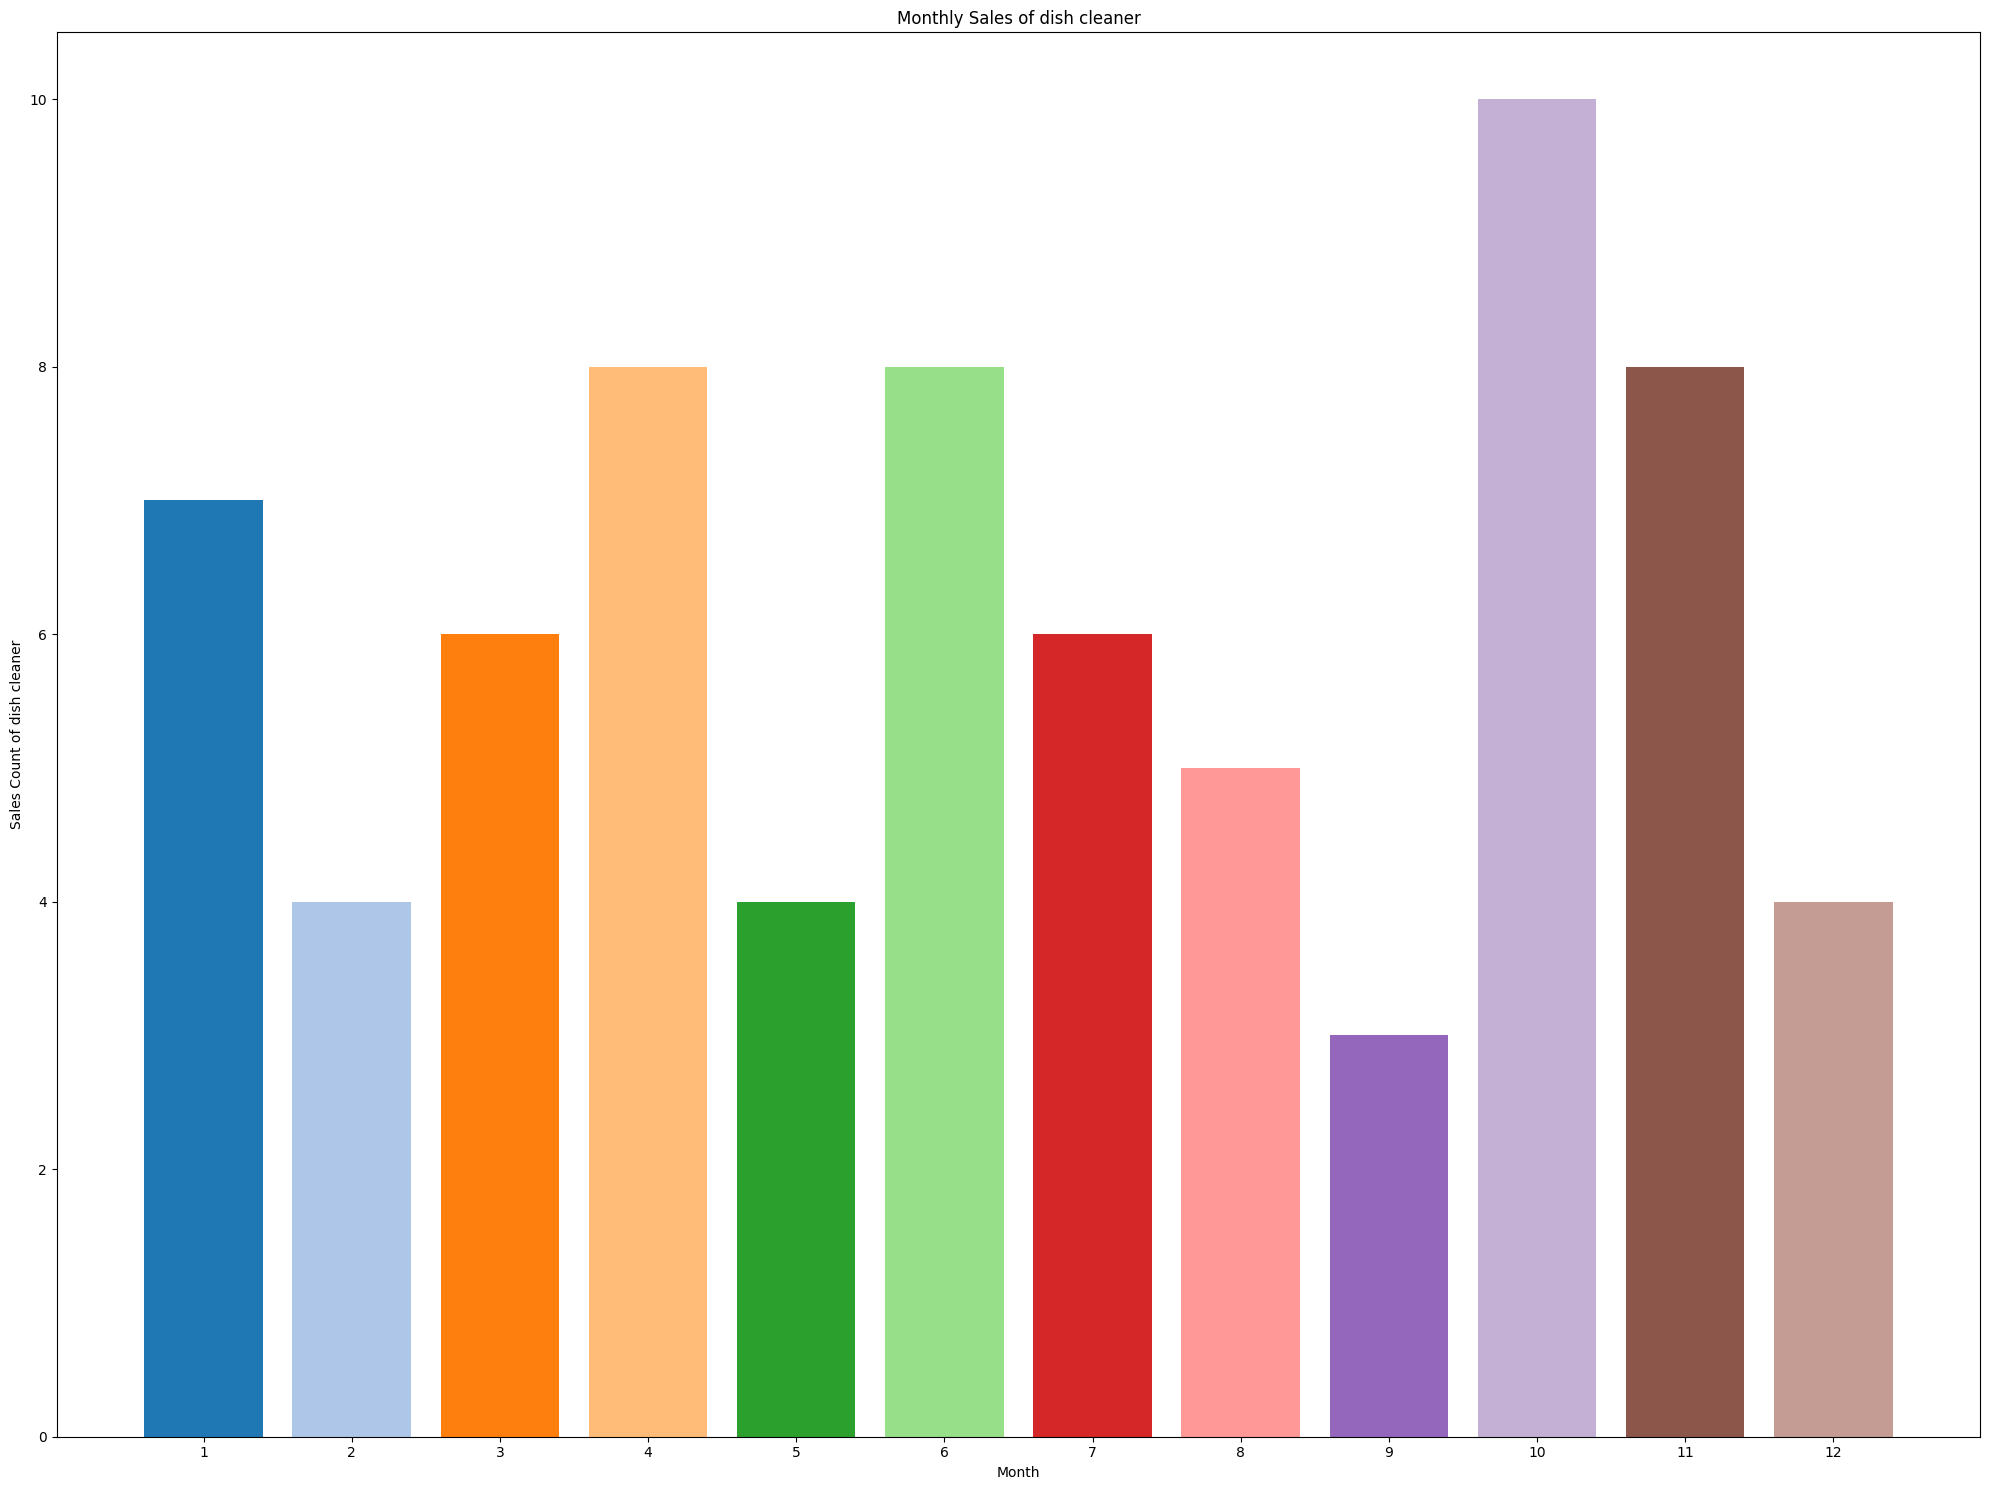

In [41]:
analysis.f3("dish cleaner")

   month  # purchases by customer 2947
0      3                             2
1      4                             3
2      7                             2


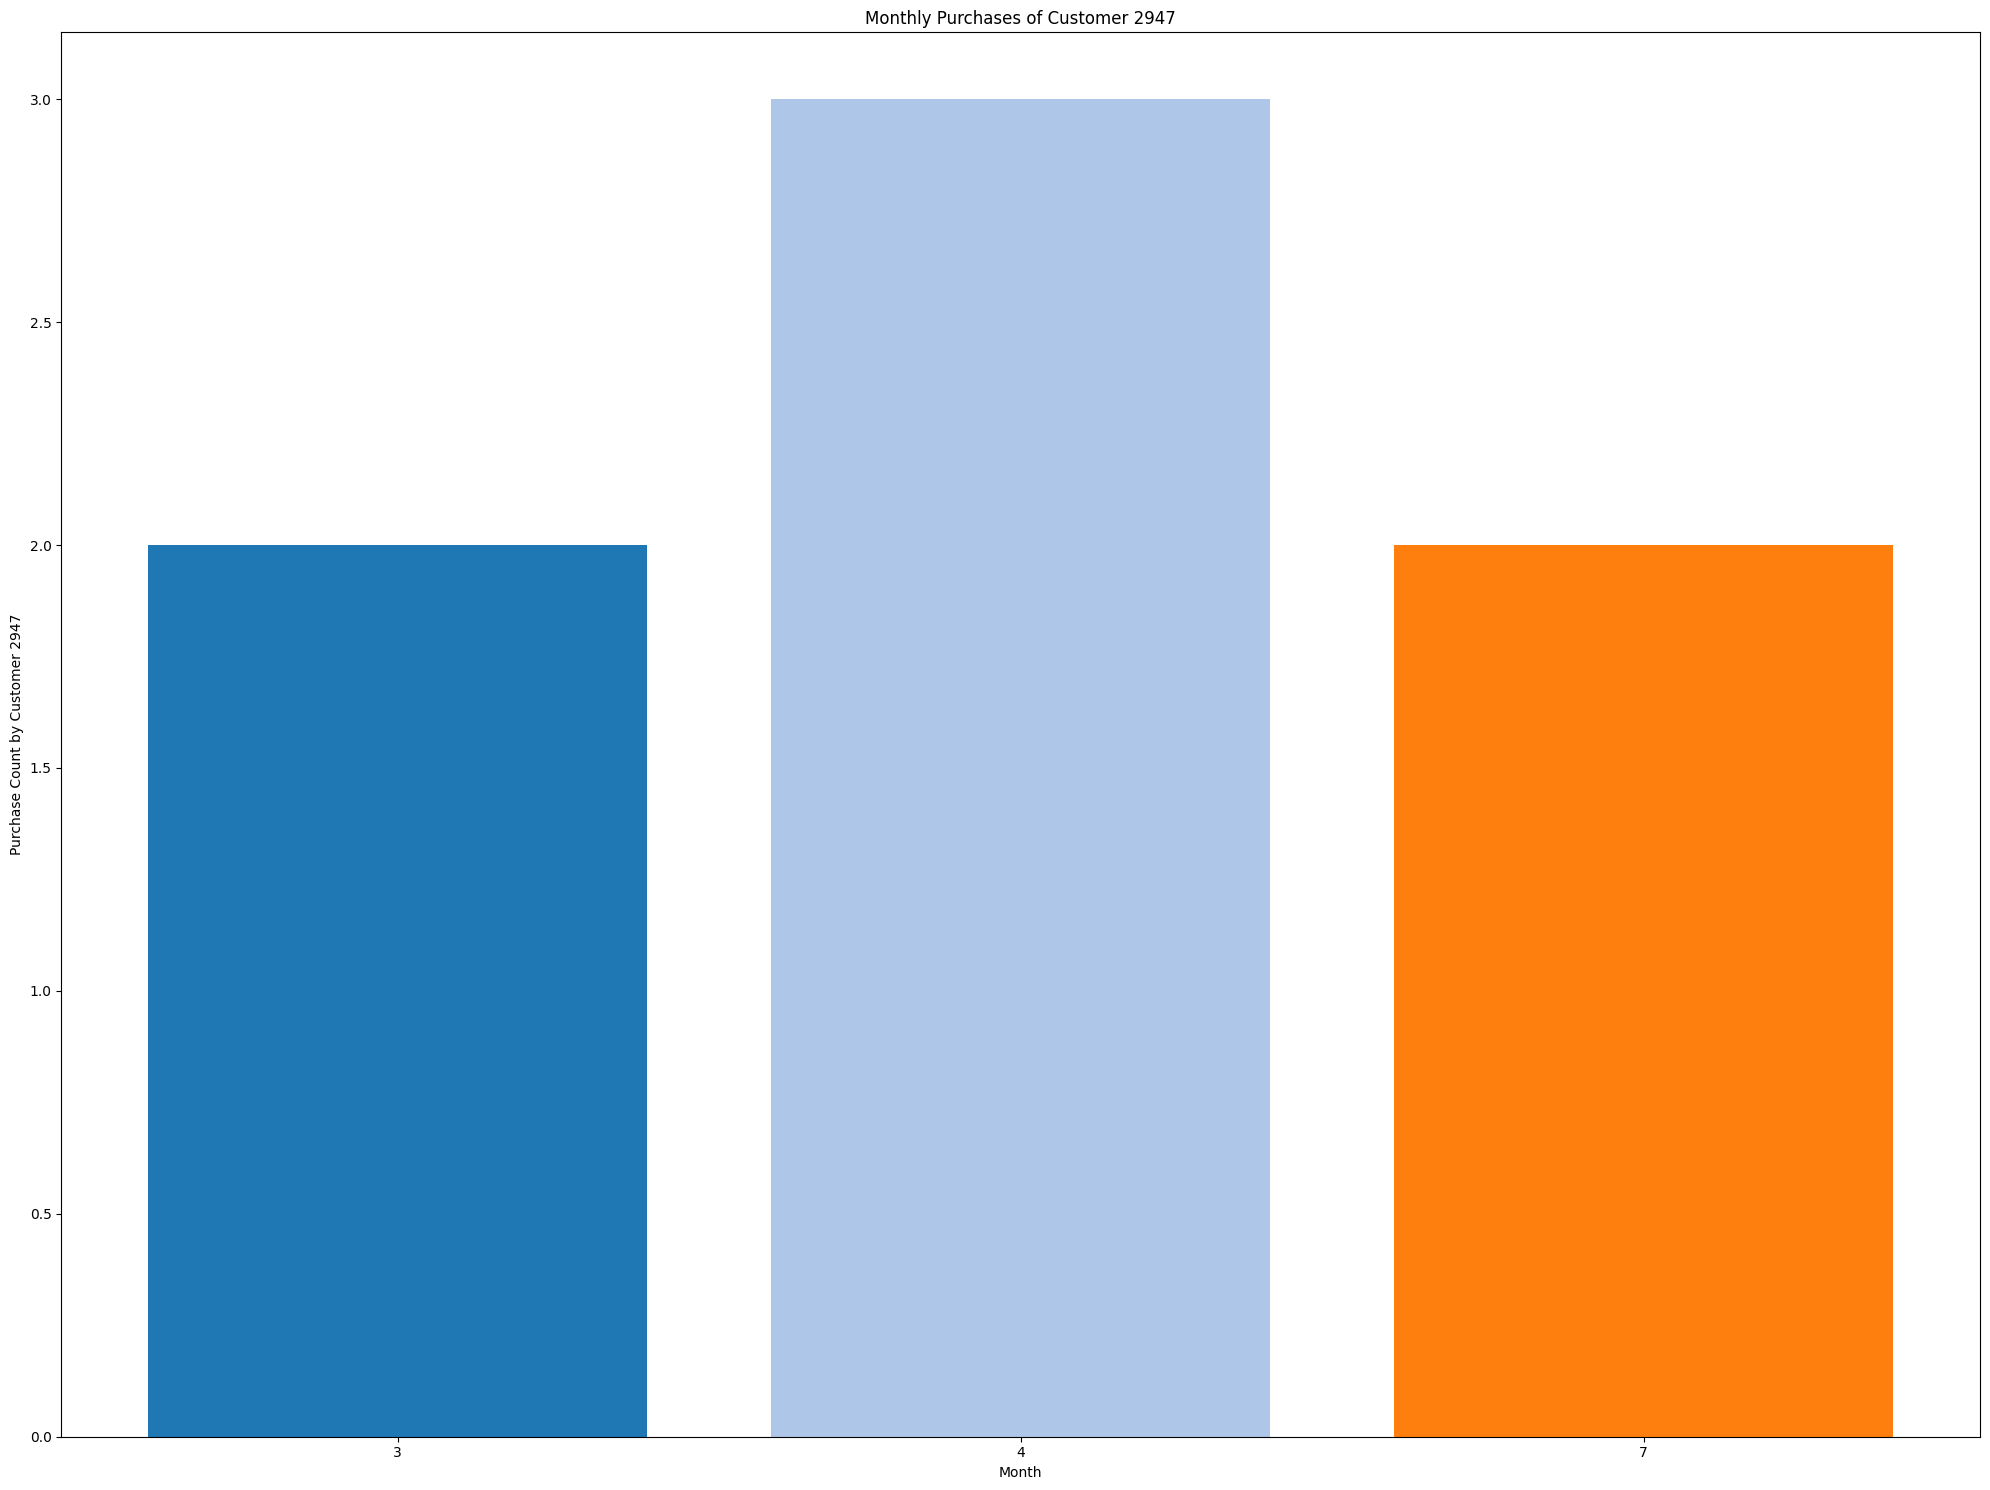

In [42]:
analysis.f4("2947")